In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import dill as pickle
import statsmodels

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
<ipython-input-1-1e75e9e9177d>:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
final_data = pd.read_pickle("tmp/final_data.pkl")

results_states = pickle.load(open('tmp/trained_models_states.pkl', 'rb'))

## White noise

In [3]:
np.random.seed(123)
dates = pd.date_range(final_data[["Updated"]].min().values[0], final_data[["Updated"]].max().values[0]).values
u0 = np.random.normal(size=len(dates))

u0 = pd.DataFrame({"Updated": dates, "Residual": u0})
u0.head()

,Updated,Residual
0,2020-02-21,-1.085631
1,2020-02-22,0.997345
2,2020-02-23,0.282978
3,2020-02-24,-1.506295
4,2020-02-25,-0.578600


<AxesSubplot:>

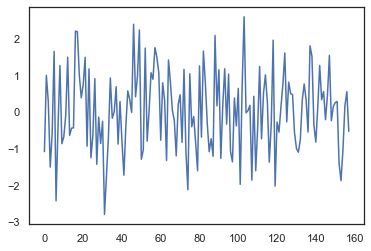

In [4]:
u0["Residual"].plot()

In [5]:
u0.to_pickle("tmp/u0.pkl")

## $h_.(t)$ linear filters

In [6]:
from functools import partial

In [7]:
linear_filters_states = {}

ORDER = 5

for state in results_states.keys():
    u0_ = u0[u0['Updated'].isin(final_data.loc[state, 'Updated'])]
    state_residual = results_states[state][1]
    t = u0_["Updated"].index.astype('float').values.reshape(-1, 1)

    def _yule_walker(u=None, coeff_=None, sigma_=None):
        return np.convolve(coeff_, u, mode="same")

    rho_, sigma_ = sm.regression.yule_walker(state_residual, order=ORDER, method="mle")
    rho_ = np.array(rho_)[::-1]
    linear_filters_states[state] = rho_, partial(
        _yule_walker, u=u0_["Residual"].values, coeff_=tuple(rho_), sigma_=sigma_
    )
        

pickle.dump(linear_filters_states, open('tmp/linear_filters_states.pkl', 'wb'))

### TODO:

AIC of 2 vs 5 => do table + plots confidence interval

if not different take 2

In [8]:
for s, (rho_, _f) in linear_filters_states.items():
    print(s, rho_)

Alaska [-0.12688484  0.05158579 -0.17635747  0.16225544  0.46988451]
Alabama [-0.02771996 -0.23026957  0.29420968 -0.24096423  0.77334275]
Arkansas [-0.06114661  0.07995801 -0.25813283  0.00571218  0.35218556]
Arizona [-0.14662606  0.01705372  0.08904552  0.13892038  0.22708921]
California [-0.18849495 -0.08267886  0.03651563  0.04703749  0.35389719]
Colorado [-0.14800096  0.16474347  0.11134649 -0.15833879  0.53387586]
Connecticut [-0.07900429 -0.09140956  0.00341867  0.00375692  0.47657744]
District of Columbia [-0.1725369   0.07391299 -0.17439742  0.1061007   0.28307325]
Delaware [-0.04728768 -0.10337387  0.00951843  0.20198746  0.6046027 ]
Florida [-0.1411092  -0.11390387  0.00125515 -0.14101652  0.33733987]
Georgia [ 0.04774817 -0.03097052 -0.17478654  0.11797469  0.38279867]
Hawaii [ 9.35004968e-05 -1.06558620e-01  4.14011595e-02 -1.64723081e-01
  5.52284673e-01]
Iowa [-0.26482817  0.1344424  -0.02238416 -0.26520841  0.62022509]
Idaho [-0.08628847  0.05111846 -0.03331571 -0.23305

In [9]:
acf, confint = statsmodels.tsa.stattools.acf(results_states["California"][1], alpha=0.05)

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [10]:
confint

array([[ 1.        ,  1.        ],
       [ 0.24075732,  0.55261004],
       [-0.00130444,  0.35626921],
       [-0.13128709,  0.23475361],
       [-0.29968553,  0.06706554],
       [-0.43870028, -0.06837933],
       [-0.21752348,  0.16931087],
       [-0.32013319,  0.06684723],
       [-0.50896709, -0.11797683],
       [-0.49931382, -0.08460153],
       [-0.46184734, -0.02760584],
       [-0.35696901,  0.09048462],
       [-0.28243421,  0.16886157],
       [-0.04721195,  0.40477821],
       [-0.14815888,  0.31065711],
       [-0.08860307,  0.37161005],
       [-0.12671622,  0.33770894],
       [-0.17201626,  0.29473363],
       [-0.19988394,  0.26764975],
       [-0.16403667,  0.30373576],
       [-0.32044871,  0.14833698],
       [-0.28683397,  0.18348555],
       [-0.29433678,  0.17653456],
       [-0.3341708 ,  0.13741654],
       [-0.33182109,  0.14175789],
       [-0.32430198,  0.15112795],
       [-0.33507468,  0.1418864 ],
       [-0.31006019,  0.16879958],
       [-0.1616754 ,